In [12]:
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [13]:
files = 'gs://hm-eu-w4/jigsaw/*/*/params*.csv'
tf.io.gfile.glob(files)

['gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/params0.955880.csv',
 'gs://hm-eu-w4/jigsaw/t03/20200427_030518_t8b/params0.955538.csv',
 'gs://hm-eu-w4/jigsaw/t03/20200427_032625_t8e/params0.957579.csv',
 'gs://hm-eu-w4/jigsaw/t03/20200427_045931_t8b/params0.953195.csv',
 'gs://hm-eu-w4/jigsaw/t03/20200427_060738_t8b/params0.953819.csv',
 'gs://hm-eu-w4/jigsaw/t04/20200427_205505_t8e/params0.953652.csv',
 'gs://hm-eu-w4/jigsaw/t04/20200427_205530_t8b/params0.959791.csv',
 'gs://hm-eu-w4/jigsaw/t04/20200427_230403_t8e/params0.951874.csv',
 'gs://hm-eu-w4/jigsaw/t04/20200428_082634_t8b/params0.960881.csv',
 'gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/params0.956153.csv',
 'gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e/params0.961137.csv',
 'gs://hm-eu-w4/jigsaw/t04/20200428_141311_t8c/params0.961828.csv']

In [24]:
pd.read_csv('gs://hm-eu-w4/jigsaw/t04/20200427_205530_t8b/params0.959791.csv').T[0]

kwargs                                                           NaN
tpu_id                                                           t8b
seed                                                               0
path                                                      jigsaw/t04
gcs                                                         hm-eu-w4
optimizer                                                      AdamW
lr                                                       5.56954e-05
weight_decay                                             7.24646e-07
dropout                                                          0.3
loss_fn                                                          bce
label_smoothing                                             0.027509
pos_weight                                                   1.29453
gamma                                                        1.70358
warm_up                                                      1.77756
epochs                            

In [15]:
df = None

for f in sorted(tf.io.gfile.glob(files)):
    score = float(os.path.basename(f)[6:-4])
    if score > 0.95:
        if df is None:
            df = pd.read_csv(f)
        else:
            df = df.append(pd.read_csv(f), ignore_index=True)

df.describe()

,seed,stages,dropout,weight_decay,warm_up,pos_weight,lr,label_smoothing,gamma,epochs,callback,batch_size,auc,kwargs,max_len
count,12.000000,9.0,12.000000,1.200000e+01,12.000000,11.000000,12.000000,12.000000,11.000000,12.000000,0.0,8.000000,12.000000,0.0,3.0
mean,49.250000,20.0,0.200670,1.180499e-05,3.758094,2.984269,0.000050,0.027138,1.363548,30.666667,NaN,27.750000,0.956777,NaN,192.0
std,35.807884,0.0,0.145278,2.460135e-05,2.136590,1.099802,0.000044,0.016103,0.786281,3.472838,NaN,0.707107,0.003427,NaN,0.0
min,0.000000,20.0,0.000000,0.000000e+00,1.467820,1.294528,0.000008,0.003234,0.349519,26.000000,NaN,26.000000,0.951874,NaN,192.0
25%,20.000000,20.0,0.075000,1.101850e-07,2.093903,2.073369,0.000019,0.009575,0.769072,29.000000,NaN,28.000000,0.953777,NaN,192.0
50%,43.500000,20.0,0.272248,7.674534e-07,2.972866,2.980220,0.000048,0.033304,1.626891,31.000000,NaN,28.000000,0.956017,NaN,192.0
75%,84.250000,20.0,0.300000,4.438052e-06,6.101325,3.933769,0.000059,0.038799,1.707968,31.500000,NaN,28.000000,0.960063,NaN,192.0
max,95.000000,20.0,0.371337,7.742110e-05,6.926963,4.594260,0.000169,0.047034,2.748896,39.000000,NaN,28.000000,0.961828,NaN,192.0


In [16]:
# df.groupby('loss').loss.count().to_frame('loss')
df.groupby('optimizer').optimizer.count().to_frame('optimizer')

,optimizer
optimizer,
AdamW,4
LAMB,8


In [17]:
df.drop(['model_id', 'kwargs', 'stages', 'amp', 'max_len', 'gcs',
         'path', 'callback', 'tpu_id', 'seed', 'dataset', 'batch_size'],
              inplace=True, axis=1)
df.sort_values(by='auc', ascending=False)

,dropout,weight_decay,warm_up,pos_weight,optimizer,one_cycle,lr,loss_fn,label_smoothing,gamma,epochs,auc,gcs_path
11,0.300000,8.102610e-07,2.199350,NaN,LAMB,NaN,0.000068,bce,0.035874,NaN,29,0.961828,gs://hm-eu-w4/jigsaw/t04/20200428_141311_t8c
10,0.371337,0.000000e+00,2.940260,4.594260,LAMB,NaN,0.000049,focal,0.034813,1.677190,31,0.961137,gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e
8,0.300000,7.742110e-05,1.467820,2.771230,LAMB,NaN,0.000048,focal,0.043990,0.349519,31,0.960881,gs://hm-eu-w4/jigsaw/t04/20200428_082634_t8b
6,0.300000,7.246458e-07,1.777561,1.294528,AdamW,NaN,0.000056,bce,0.027509,1.703583,26,0.959791,NaN
2,0.129303,3.713744e-07,6.086450,3.263595,LAMB,True,0.000169,focal,0.038399,1.626891,39,0.957579,NaN
9,0.100000,9.489748e-06,3.005472,2.003214,AdamW,NaN,0.000076,focal,0.008301,0.910586,31,0.956153,NaN
0,0.251823,2.754154e-06,6.862824,3.862004,LAMB,True,0.000031,focal,0.047034,2.748896,31,0.955880,NaN
1,0.000000,1.469134e-07,3.754905,1.721458,AdamW,True,0.000010,bce,0.003234,0.669243,33,0.955538,NaN
4,0.000000,2.725716e-06,1.694357,2.980220,LAMB,True,0.000022,focal,0.031796,0.391764,26,0.953819,NaN
5,0.362907,0.000000e+00,6.145949,4.005534,LAMB,NaN,0.000010,focal,0.010000,1.712352,33,0.953652,NaN


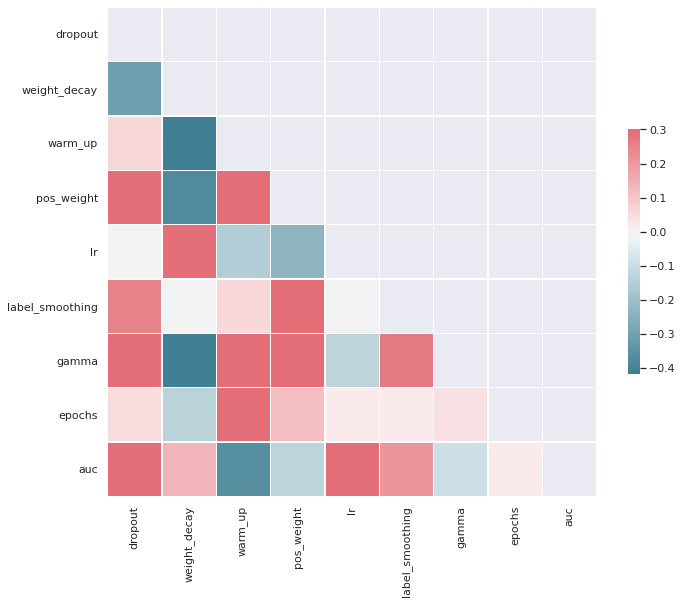

In [18]:
# Compute the correlation matrix
corr = df.corr('kendall')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
preds, oof, scores = [], [], []

for f in sorted(tf.io.gfile.glob(files)):
    score = float(os.path.basename(f)[6:-4])
    if score < 0.95:
        continue
    folder = os.path.dirname(f)
    sub = os.path.join(folder, 'submission.csv')
    print(score, sub)
    sub = pd.read_csv(sub)
    sub.to_csv(f'submission_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)
    preds.append(sub.toxic.values)

    valid = pd.read_csv(os.path.join(folder, 'valid_oof.csv'))
    oof.append(valid.pred.values)
    scores.append(score)
    
!ls -sh *.csv

0.95588 gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/submission.csv
0.955538 gs://hm-eu-w4/jigsaw/t03/20200427_030518_t8b/submission.csv
0.957579 gs://hm-eu-w4/jigsaw/t03/20200427_032625_t8e/submission.csv
0.953195 gs://hm-eu-w4/jigsaw/t03/20200427_045931_t8b/submission.csv
0.953819 gs://hm-eu-w4/jigsaw/t03/20200427_060738_t8b/submission.csv
0.953652 gs://hm-eu-w4/jigsaw/t04/20200427_205505_t8e/submission.csv
0.959791 gs://hm-eu-w4/jigsaw/t04/20200427_205530_t8b/submission.csv
0.951874 gs://hm-eu-w4/jigsaw/t04/20200427_230403_t8e/submission.csv
0.960881 gs://hm-eu-w4/jigsaw/t04/20200428_082634_t8b/submission.csv
0.956153 gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/submission.csv
0.961137 gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e/submission.csv
0.961828 gs://hm-eu-w4/jigsaw/t04/20200428_141311_t8c/submission.csv
1.5M submission_avg10.csv
1.5M submission_avg12.csv
1.5M submission_decorr10.csv
1.5M submission_decorr12.csv
1.6M submission_decorr13.csv
1.6M submission_decorr5.csv
1.6M s

[0.0632843  0.06582325 0.064074   0.06606743 0.06443819 0.12080176
 0.12080176 0.12080176 0.06413096 0.12080176 0.06434549 0.06462935]


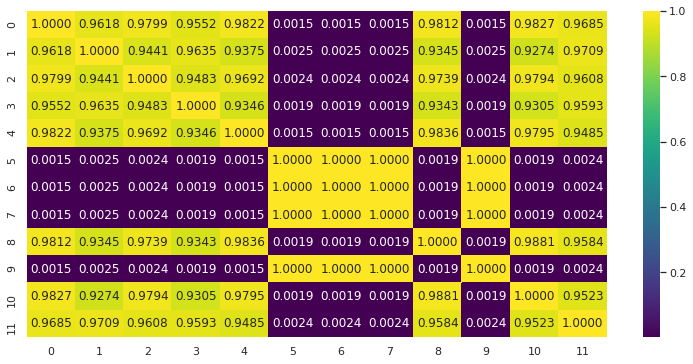

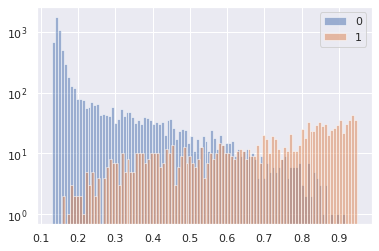

AUC: 0.959405074996097 toxic: 0.15375 pred: 0.29480725405150227 ratio: 0.176125


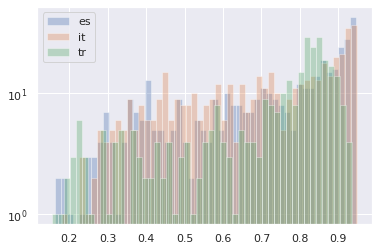

In [20]:
corr_mat = np.corrcoef(preds)
# print(corr_mat)

weights = (1-corr_mat).sum(axis=0) # gain
weights /= weights.sum()
print(weights)

fig, ax = plt.subplots(figsize=(len(preds)+1, len(preds)//2))
ax = sns.heatmap(corr_mat, cmap='viridis', annot=True, fmt="0.04f", ax=ax)
plt.show()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
sub.to_csv(f'submission_decorr{len(preds)}.csv', index=False)
valid['pred'] = np.average(oof, weights=weights, axis=0)
valid.to_csv(f'valid_decorr{len(preds)}.csv', index=False)

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())

[0.08115909 0.08053482 0.08440959 0.07650335 0.07753706 0.07725768
 0.08905318 0.07440342 0.09153453 0.0816644  0.09213749 0.09380539]


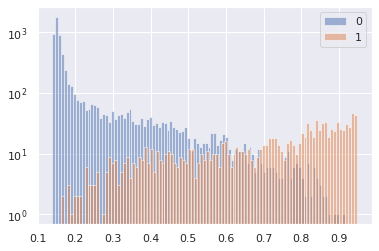

AUC: 0.9591071321348369 toxic: 0.15375 pred: 0.30124464029551784 ratio: 0.180625


('mean score:', 0.9567772500000001)

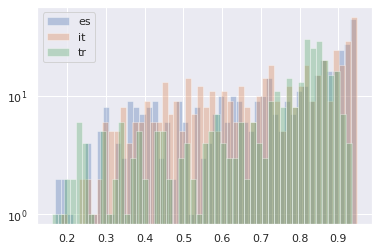

In [9]:
# weight by score
weights = 1 / (1-np.array(scores))
weights /= weights.sum()
print(weights)

sub['toxic'] = np.average(preds, weights=weights, axis=0)
sub.to_csv(f'submission_score_blend{len(preds)}.csv', index=False)
valid['pred'] = np.average(oof, weights=weights, axis=0)
# valid.to_csv(f'valid_score_blend{len(preds)}.csv', index=False)

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())

'mean score:', np.mean(scores)

[0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]


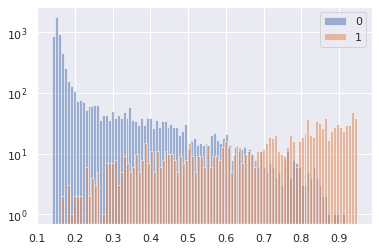

AUC: 0.9589338425142007 toxic: 0.15375 pred: 0.3023304307455494 ratio: 0.1805


('mean score:', 0.9567772500000001)

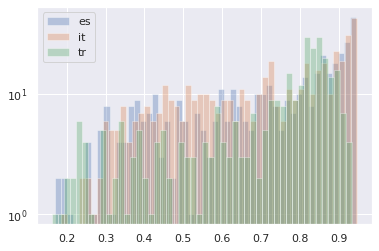

In [10]:
# average
weights = np.ones_like(scores)
weights /= weights.sum()
print(weights)

sub['toxic'] = np.average(preds, weights=weights, axis=0)
sub.to_csv(f'submission_avg{len(preds)}.csv', index=False)
valid['pred'] = np.average(oof, weights=weights, axis=0)
# valid.to_csv(f'valid_score_blend{len(preds)}.csv', index=False)

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())

'mean score:', np.mean(scores)

In [11]:
# clean up
folders = 'gs://hm-eu-w4/jigsaw/*/*/*'
for f in tf.io.gfile.glob(folders):
    n_items = len(tf.io.gfile.glob(os.path.join(f, 'best_model.tf*')))
    print(f, n_items, len(tf.io.gfile.glob(os.path.join(f, '*'))))
    if n_items > 0:
        params = tf.io.gfile.glob(os.path.join(f, 'params*.csv'))
        if len(params) == 0:
            print(f, n_items, tf.io.gfile.glob(os.path.join(f, '*')))
            !gsutil -m rm -r {f}
        else:
            score = float(os.path.basename(params[0])[6:-4])
            if score < 0.95:
                !gsutil rm -r {f}
#     elif n_items == 0:
#         !gsutil rm -r {f}

gs://hm-eu-w4/jigsaw/t02/20200426_161827_t8e/ 0 0
gs://hm-eu-w4/jigsaw/t02/20200426_172014_t8b/ 0 0
gs://hm-eu-w4/jigsaw/t02/20200426_181251_t8e/ 0 1
gs://hm-eu-w4/jigsaw/t02/20200426_181251_t8e/sub_hist.png 0 0
gs://hm-eu-w4/jigsaw/t02/20200426_185232_t8b/ 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011555_t8b/ 0 1
gs://hm-eu-w4/jigsaw/t03/20200427_011555_t8b/valid_toxic_hist.png 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/ 3 11
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/best_model.tf.data-00000-of-00002 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/best_model.tf.data-00001-of-00002 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/best_model.tf.index 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/checkpoint 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/history.png 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/params0.955880.csv 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/sub_hist.png 0 0
gs://hm-eu-w4/jigsaw/t03/20200427_011557_t8e/submission.csv 0 0
gs://hm-eu-w4/jig

gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/checkpoint 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/history.csv 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/history.png 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/params0.956153.csv 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/sub_hist.png 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/submission.csv 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/valid_hist.png 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/valid_oof.csv 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_110712_t8b/valid_toxic_hist.png 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e/ 3 12
gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e/best_model.tf.data-00000-of-00002 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e/best_model.tf.data-00001-of-00002 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e/best_model.tf.index 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e/checkpoint 0 0
gs://hm-eu-w4/jigsaw/t04/20200428_134130_t8e/history.csv 0 0
gs://hm-eu-w4/jigsaw

In [12]:
# import pdb; pdb.pm()